# **Temporal Difference Learning for Windy Gridworld Environment**

Reference Book from which we are producing the figures for this project, and the equations & page numbers referered from is:

Reinforcement Learning: An Introduction (second edition) by Richard S. Sutton and Andrew G. Barto 

# Windy gridworld

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import time
from datetime import datetime, timedelta    
from tqdm import trange, tqdm
import gym
from typing import Callable, Tuple, Optional, List
import math
from tqdm import trange
from enum import IntEnum
from gym import Env, spaces
from gym.utils import seeding
from gym.envs.registration import register

In [2]:
class WindyGridWorld(object):
    def __init__(self, enable_king_move=False, enable_no_move=False):
        # define the grid space
        self.grid = np.zeros((7, 10))

        # define the state space
        self.state_space = [[r, c] for r, c in zip(np.where(self.grid == 0.0)[0],
                                                   np.where(self.grid == 0.0)[1])]

        # define the start state
        self.start_state = [3, 0]   

        # define the goal state
        self.goal_state = [3, 7]

        # define the wind
        self.wind = np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0], dtype=int)

        # Define an ordered list of actions
        if enable_king_move:
            self.action_list = ["up", "down", "left", "right",
                                "up-left", "up-right", "down-left", "down-right"]
            if enable_no_move:
                self.action_list.append("no-move")
            self.action_space = {
                "up": np.array([-1, 0]),
                "down": np.array([1, 0]),
                "left": np.array([0, -1]),
                "right": np.array([0, 1]),
                "up-left": np.array([-1, -1]),
                "up-right": np.array([-1, 1]),
                "down-left": np.array([1, -1]),
                "down-right": np.array([1, 1])
            }
            if enable_no_move:
                self.action_space["no-move"] = np.array([0, 0])  # No movement action
        else:
            self.action_list = ["up", "down", "left", "right"]
            self.action_space = {
                "up": np.array([-1, 0]),
                "down": np.array([1, 0]),
                "left": np.array([0, -1]),
                "right": np.array([0, 1])
            }

        # Track the current state
        self.state = None

    def reset(self):
        # Reset the agent to the start state
        self.state = self.start_state.copy()
        terminated = False
        return self.state, terminated

    def step(self, act):
        # Get current row and column
        row, col = self.state

        # Map action index to action name using the ordered list
        action = self.action_list[act]
        move = self.action_space[action]

        # Apply the move based on the action
        new_row = row + move[0]
        new_col = col + move[1]

        # Apply wind effect: wind shifts the agent upward based on the current column
        new_row -= self.wind[col]

        # Ensure the agent doesn't move out of bounds (grid boundary conditions)
        new_row = int(np.clip(new_row, 0, self.grid.shape[0] - 1))  # rows in [0, num_rows-1]
        new_col = int(np.clip(new_col, 0, self.grid.shape[1] - 1))  # columns in [0, num_cols-1]

        # Update the agent's state
        self.state = [new_row, new_col]

        # Define the reward: -1 for every step, 0 if the goal is reached
        if self.state == self.goal_state:
            reward = 0
            terminated = True
        else:
            reward = -1
            terminated = False

        return self.state, reward, terminated

    def render(self):
        # Plot the agent and the goal
        plot_arr = self.grid.copy()
        plot_arr[self.state[0], self.state[1]] = 1.0
        plot_arr[self.goal_state[0], self.goal_state[1]] = 2.0
        plt.clf()
        fig, arr = plt.subplots(1, 1)
        arr.set_title(f"state={self.state}")
        arr.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(1)
        plt.close(fig)

In [3]:
class SARSA(object):
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        # Define the parameters
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        # Environment
        self.env = env

        # Define the Q value table
        self.state_num = len(self.env.state_space)
        self.action_num = len(self.env.action_list)
        self.Q = np.zeros((self.state_num, self.action_num))

        # Define the timeout
        self.timeout = timeout

    def behavior_policy(self, state):
        if np.random.rand() < self.epsilon:  # Explore
            action = np.random.choice(self.action_num)
        else:  # Exploit
            state_idx = self.env.state_space.index(state)
            action = np.argmax(self.Q[state_idx])
        return action

    def update(self, s, a, r, s_prime, a_prime):
        s_idx = self.env.state_space.index(s)
        s_prime_idx = self.env.state_space.index(s_prime)
        td_target = r + self.gamma * self.Q[s_prime_idx, a_prime]
        td_error = td_target - self.Q[s_idx, a]
        self.Q[s_idx, a] += self.alpha * td_error

    def run(self):
        results = []  # To track episodes completed over time steps
        episode_count = 0  # Count how many episodes have been completed
        terminated = True  # Initialize terminated

        for t in range(self.timeout):
            # Start a new episode if it's the first step or if the previous episode terminated
            if t == 0 or terminated:
                s, terminated = self.env.reset()
                a = self.behavior_policy(s)
                episode_count += 1  # Increment episode count when a new episode starts

            # Take a step
            s_prime, reward, terminated = self.env.step(a)
            a_prime = self.behavior_policy(s_prime)
            self.update(s, a, reward, s_prime, a_prime)

            # Update current state and action
            s = s_prime
            a = a_prime

            # Track number of episodes completed at this time step
            results.append(episode_count)

        return results

In [4]:
class ExpectedSARSA(object):
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        # Define the parameters
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        # Environment
        self.env = env

        # Define the Q value table
        self.state_num = len(self.env.state_space)
        self.action_num = len(self.env.action_list)
        self.Q = np.zeros((self.state_num, self.action_num))

        # Define the timeout
        self.timeout = timeout

    def behavior_policy(self, state):
        if np.random.rand() < self.epsilon:  # Explore
            action = np.random.choice(self.action_num)
        else:  # Exploit
            state_idx = self.env.state_space.index(state)
            action = np.argmax(self.Q[state_idx])
        return action

    def update(self, s, a, r, s_prime, a_prime):
        s_idx = self.env.state_space.index(s)
        s_prime_idx = self.env.state_space.index(s_prime)

        expected_value = 0
        greedy_action = np.argmax(self.Q[s_prime_idx])

        for action in range(self.action_num):
            if action == greedy_action:
                prob = 1 - self.epsilon + (self.epsilon / self.action_num)
            else:
                prob = self.epsilon / self.action_num
            expected_value += prob * self.Q[s_prime_idx, action]

        td_target = r + self.gamma * expected_value
        td_error = td_target - self.Q[s_idx, a]
        self.Q[s_idx, a] += self.alpha * td_error

    def run(self):
        results = []
        episode_count = 0
        terminated = True  # Initialize terminated

        for t in range(self.timeout):
            if t == 0 or terminated:
                s, terminated = self.env.reset()
                a = self.behavior_policy(s)
                episode_count += 1

            s_prime, reward, terminated = self.env.step(a)
            a_prime = self.behavior_policy(s_prime)
            self.update(s, a, reward, s_prime, a_prime)

            s = s_prime
            a = a_prime

            results.append(episode_count)

        return results

In [5]:
class QLearning(object):
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        # Define the parameters
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        # Environment
        self.env = env

        # Define the Q value table
        self.state_num = len(self.env.state_space)
        self.action_num = len(self.env.action_list)
        self.Q = np.zeros((self.state_num, self.action_num))

        # Define the timeout
        self.timeout = timeout

    def behavior_policy(self, state):
        if np.random.rand() < self.epsilon:  # Explore
            action = np.random.choice(self.action_num)
        else:  # Exploit
            state_idx = self.env.state_space.index(state)
            action = np.argmax(self.Q[state_idx])
        return action

    def update(self, s, a, r, s_prime):
        s_idx = self.env.state_space.index(s)
        s_prime_idx = self.env.state_space.index(s_prime)

        max_q_value = np.max(self.Q[s_prime_idx])
        td_target = r + self.gamma * max_q_value
        td_error = td_target - self.Q[s_idx, a]
        self.Q[s_idx, a] += self.alpha * td_error

    def run(self):
        results = []
        episode_count = 0
        terminated = True  # Initialize terminated

        for t in range(self.timeout):
            if t == 0 or terminated:
                s, terminated = self.env.reset()
                episode_count += 1

            a = self.behavior_policy(s)
            s_prime, reward, terminated = self.env.step(a)
            self.update(s, a, reward, s_prime)

            s = s_prime

            results.append(episode_count)

        return results

In [6]:
def plot_curves(arr_list, legend_list, color_list, ylabel, string_12):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

    Make sure the elements in the arr_list, legend_list, and color_list are associated with each other correctly.
    Do not forget to change the ylabel for different plots.
    """
    # Clear the current figure
    plt.clf()
    fig, ax = plt.subplots(figsize=(12, 8))

    # Set labels
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # Plot results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # Compute the mean and standard error while ignoring NaN values
        mean_arr = np.nanmean(arr, axis=0)
        arr_err = np.nanstd(arr, axis=0) / np.sqrt(np.sum(~np.isnan(arr), axis=0))

        # Plot the mean
        h, = ax.plot(range(len(mean_arr)), mean_arr, color=color, label=legend)

        # Plot the confidence band
        arr_err = 1.96 * arr_err  # 95% confidence interval
        ax.fill_between(range(len(mean_arr)),
                        mean_arr - arr_err,
                        mean_arr + arr_err,
                        alpha=0.3, color=color)
        # Save the plot handle
        h_list.append(h)

    # Set the title
    ax.set_title("Windy Gridworld Results " + string_12)
    ax.legend(handles=h_list)
    plt.show()

In [7]:
def run_on_policy_td_control(run_num, timeout, enable_king_move_actions=False, enable_no_move_actions=False, string_12="Normal Moves"):
    # Create the environment
    env = WindyGridWorld(enable_king_move=enable_king_move_actions, enable_no_move=enable_no_move_actions)

    # Parameters
    epsilon = 0.1
    alpha = 0.5
    gamma = 1.0

    # Run Expected SARSA
    expected_sarsa_results_list = []
    for _ in range(run_num):
        controller_expected_sarsa = ExpectedSARSA(env, alpha, epsilon, gamma, timeout)
        episodes = controller_expected_sarsa.run()
        expected_sarsa_results_list.append(episodes[0:8000])

    # Run SARSA
    sarsa_results_list = []
    for _ in range(run_num):
        controller_sarsa = SARSA(env, alpha, epsilon, gamma, timeout)
        episodes = controller_sarsa.run()
        sarsa_results_list.append(episodes[0:8000])

    # Run Q-Learning
    q_learning_results_list = []
    for _ in range(run_num):
        controller_q_learning = QLearning(env, alpha, epsilon, gamma, timeout)
        episodes = controller_q_learning.run()
        q_learning_results_list.append(episodes[0:8000])

    sarsa_array = np.array(sarsa_results_list)
    expected_sarsa_array = np.array(expected_sarsa_results_list)
    q_learning_array = np.array(q_learning_results_list)

    # Plot the results
    plot_curves(
        [sarsa_array, expected_sarsa_array, q_learning_array],
        ['SARSA', 'Expected SARSA', 'Q-learning'],
        ['r', 'b', 'g'],
        "Episodes",
        string_12
    )

<Figure size 640x480 with 0 Axes>

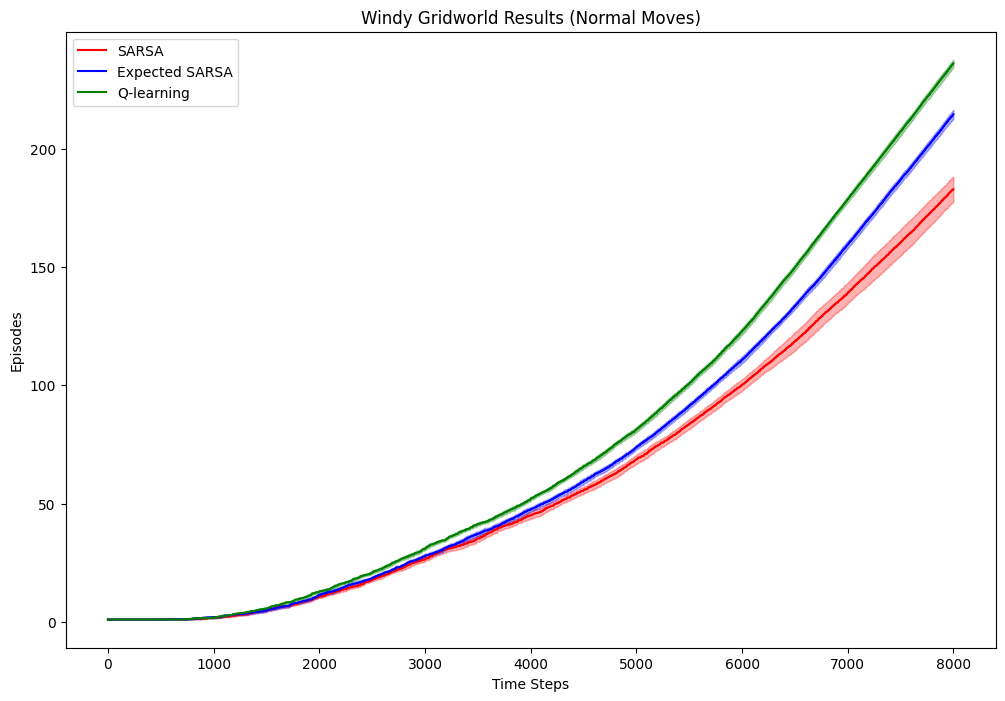

<Figure size 640x480 with 0 Axes>

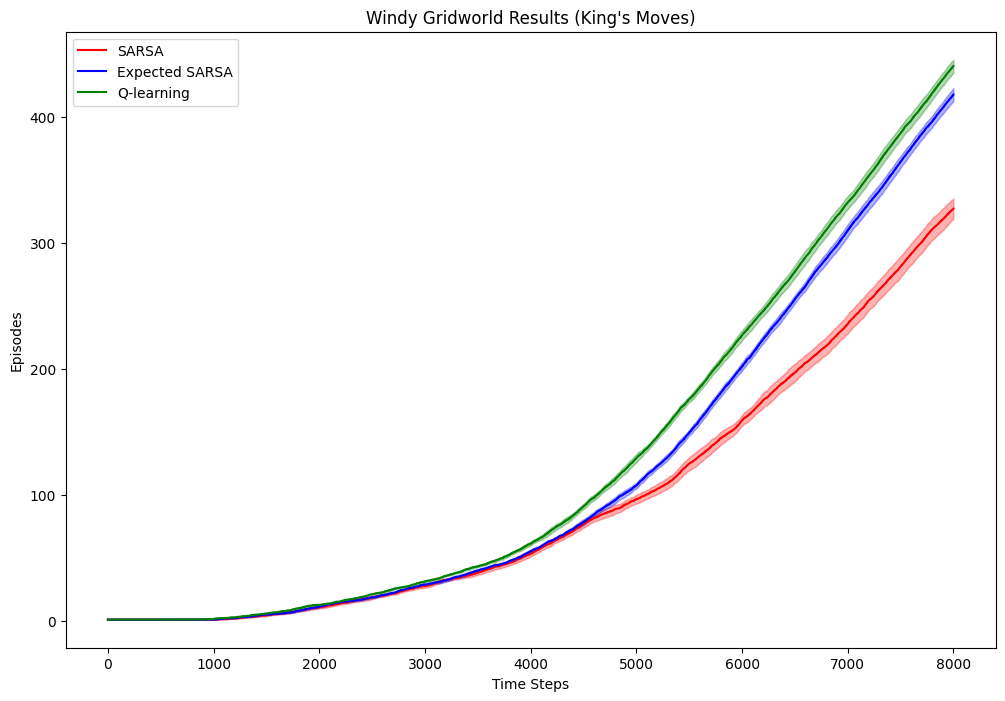

<Figure size 640x480 with 0 Axes>

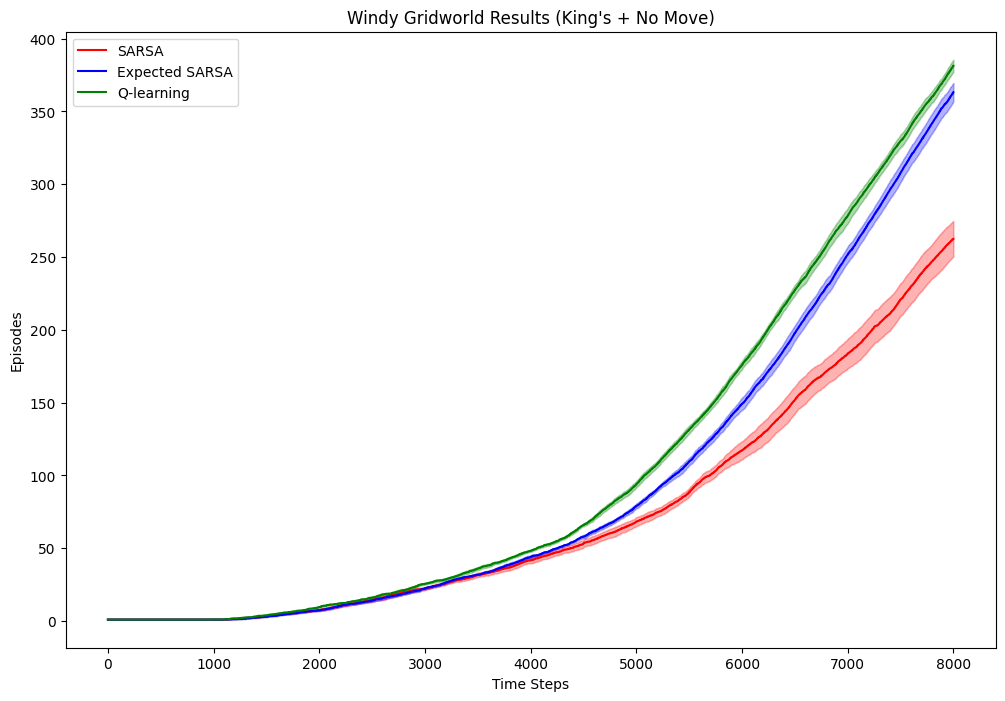

In [8]:
if __name__ == "__main__":
    # Set randomness
    np.random.seed(1234)
    random.seed(1234)

    # Trial number
    trial_num = 10
    # Maximal time steps
    max_time_steps = 8000

    # Run SARSA and Q-Learning
    ## Normal Moves (Up, Down, Left, Right)
    run_on_policy_td_control(trial_num, max_time_steps, enable_king_move_actions=False, enable_no_move_actions=False, string_12="(Normal Moves)")

    ## King's moves (Other than the normal moves, the agent can move diagonally which adds 4 actions)
    run_on_policy_td_control(trial_num, max_time_steps, enable_king_move_actions=True, enable_no_move_actions=False, string_12="(King's Moves)")
    ## No move (Other than the 8 possible actions (normal and king's moves), there is a 9th action which is for no movement.)
    run_on_policy_td_control(trial_num, max_time_steps, enable_king_move_actions=True, enable_no_move_actions=True, string_12="(King's + No Move)")

# Bias-variance trade-off
- We have created our own TD(0) and Monte Carlo classes.
- We will continue with the original windy gridworld domain. 
- A fixed policy π will be specified to collect episodes.
- A certain number of “training” episodes N ∈ {1, 10, 50} will be collected.
- Each method being investigated ( On-policy TD(0), On-policy Monte-Carlo prediction) will learn to estimate the state-value.
function using the N “training“ episodes, respectively.
- We then evaluate the distribution of learning targets each method experiences at a specified state S. Here, S is the initial state marked as S in the Example 6.5.
- In order to implement this we will collect additional 100 “evaluation” episodes. Instead of using these to perform
further updates to the state-value function, we will instead evaluate the distribution of learning targets
V(S) based on the “evaluation” episodes. For example, TD(0) will experience a set of {R+ V(S′)} targets,
whereas Monte-Carlo will experience a set of {G} targets.

In [9]:
##USING THE GRID WORLD ENVIRONMENT CLASS FROM THE PREVIOUS CELLS WITH SOME MINOR MODIFICATIONS#####################

class WindyGridWorldEnv(Env):
    def __init__(self, enable_king_move=False, enable_no_move=False):
        """Windy grid world gym environment integrated from CODE-2."""
        # define the grid space
        self.grid = np.zeros((7, 10))

        # define the state space
        self.state_space = [[r, c] for r in range(self.grid.shape[0])
                            for c in range(self.grid.shape[1])]

        # define the start state
        self.start_state = [3, 0]

        # define the goal state
        self.goal_state = [3, 7]

        # define the wind
        self.wind = np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0], dtype=int)

        # Define an ordered list of actions
        if enable_king_move:
            self.action_list = ["up", "down", "left", "right",
                                "up-left", "up-right", "down-left", "down-right"]
            if enable_no_move:
                self.action_list.append("no-move")
            self.action_space_dict = {
                "up": np.array([-1, 0]),
                "down": np.array([1, 0]),
                "left": np.array([0, -1]),
                "right": np.array([0, 1]),
                "up-left": np.array([-1, -1]),
                "up-right": np.array([-1, 1]),
                "down-left": np.array([1, -1]),
                "down-right": np.array([1, 1])
            }
            if enable_no_move:
                self.action_space_dict["no-move"] = np.array([0, 0])  # No movement action
        else:
            self.action_list = ["up", "down", "left", "right"]
            self.action_space_dict = {
                "up": np.array([-1, 0]),
                "down": np.array([1, 0]),
                "left": np.array([0, -1]),
                "right": np.array([0, 1])
            }

        # Define gym spaces
        self.action_space = spaces.Discrete(len(self.action_list))
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(self.grid.shape[0]), spaces.Discrete(self.grid.shape[1]))
        )

        # Track the current state
        self.state = None

    def reset(self):
        # Reset the agent to the start state
        self.state = self.start_state.copy()
        return tuple(self.state)

    def step(self, act):
        # Get current row and column
        row, col = self.state

        # Map action index to action name using the ordered list
        action = self.action_list[act]
        move = self.action_space_dict[action]

        # Apply the move based on the action
        new_row = row + move[0]
        new_col = col + move[1]

        # Apply wind effect: wind shifts the agent upward based on the current column
        new_row -= self.wind[col]

        # Ensure the agent doesn't move out of bounds (grid boundary conditions)
        new_row = int(np.clip(new_row, 0, self.grid.shape[0] - 1))  # rows in [0, num_rows-1]
        new_col = int(np.clip(new_col, 0, self.grid.shape[1] - 1))  # columns in [0, num_cols-1]

        # Update the agent's state
        self.state = [new_row, new_col]

        # Define the reward: -1 for every step, 0 if the goal is reached
        if self.state == self.goal_state:
            reward = 0
            terminated = True
        else:
            reward = -1
            terminated = False

        return tuple(self.state), reward, terminated, {}

    def render(self):
        # Plot the agent and the goal
        plot_arr = self.grid.copy()
        plot_arr[self.state[0], self.state[1]] = 1.0
        plot_arr[self.goal_state[0], self.goal_state[1]] = 2.0
        plt.clf()
        fig, arr = plt.subplots(1, 1)
        arr.set_title(f"state={self.state}")
        arr.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(1)
        plt.close(fig)



##USING THE SARSA CLASS FROM THE PREVIOUS CELLS WITH SOME MINOR MODIFICATIONS#####################

class SARSAAgent:
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        # Define the parameters
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        # Environment
        self.env = env

        # Define the Q value table
        self.state_num = len(self.env.state_space)
        self.action_num = len(self.env.action_list)
        self.Q = defaultdict(lambda: np.zeros(self.action_num))

        # Define the timeout
        self.timeout = timeout

    def behavior_policy(self, state):
        if np.random.rand() < self.epsilon:  # Explore
            action = np.random.choice(self.action_num)
        else:  # Exploit
            action_values = self.Q[state]
            action = np.random.choice(
                np.flatnonzero(action_values == action_values.max())
            )
        return action

    def update(self, s, a, r, s_prime, a_prime):
        td_target = r + self.gamma * self.Q[s_prime][a_prime]
        td_error = td_target - self.Q[s][a]
        self.Q[s][a] += self.alpha * td_error

    def run(self):
        results = []  # To track episodes completed over time steps
        episode_count = 0  # Count how many episodes have been completed
        terminated = True  # Initialize terminated

        for t in range(self.timeout):
            # Start a new episode if it's the first step or if the previous episode terminated
            if t == 0 or terminated:
                s = self.env.reset()
                a = self.behavior_policy(s)
                episode_count += 1  # Increment episode count when a new episode starts
                terminated = False

            # Take a step
            s_prime, reward, terminated, _ = self.env.step(a)
            if terminated:
                a_prime = None
                self.Q[s][a] += self.alpha * (reward - self.Q[s][a])
            else:
                a_prime = self.behavior_policy(s_prime)
                self.update(s, a, reward, s_prime, a_prime)

            # Update current state and action
            s = s_prime
            a = a_prime

            # Track number of episodes completed at this time step
            results.append(episode_count)

        return results

In [10]:
def plot_histogram(values, color, title, reference_value=None):
    # Plot a histogram of target values with an optional reference line for the true value
    plt.hist(values, bins=30, color=color, alpha=0.7, edgecolor='black')
    plt.xlabel('Target Values')
    plt.ylabel('Frequency')
    plt.title(title)
    
    # If a reference value is provided, display it as a vertical line on the histogram
    if reference_value is not None:
        plt.axvline(x=reference_value, color='green', linestyle='dashed', linewidth=2, label=f'True Value: {reference_value:.2f}')
        plt.legend()
    plt.show()

def epsilon_policy(Q_map, current_state, action_space_size, epsilon=0.1):
    # Implements an epsilon-greedy policy for action selection based on Q-values
    # With probability epsilon, choose a random action
    if np.random.rand() < epsilon:
        return np.random.choice(action_space_size)
    else:
        # Otherwise, choose the action that maximizes the Q-value for the current state
        q_values = Q_map[current_state]
        return np.random.choice(np.flatnonzero(q_values == q_values.max()))

def create_episodes(environment, policy, num_episodes):
    # Generate a specified number of episodes using the provided policy
    episode_list = []
    
    for _ in range(num_episodes):
        single_episode = []  # Store each episode as a sequence of transitions
        state = environment.reset()  # Start from the initial state
        done = False
        
        # Simulate the episode until a terminal state is reached
        while not done:
            chosen_action = policy(state)  # Select an action based on the policy
            next_state, reward, done, _ = environment.step(chosen_action)  # Step in the environment
            single_episode.append((state, chosen_action, reward, next_state))  # Log transition
            state = next_state  # Move to the next state
            
        episode_list.append(single_episode)  # Append completed episode to the list
    return episode_list

def td_prediction_stepwise(episodes, value_function, policy, alpha=0.1, gamma=1.0):
    # Perform TD(0) prediction to update value function from observed episodes
    for episode in episodes:
        for state, action, reward, next_state in episode:
            # Update value of each state based on TD(0) formula
            # V(s) <- V(s) + alpha * [reward + gamma * V(next_state) - V(s)]
            value_function[state] += alpha * (reward + gamma * value_function[next_state] - value_function[state])
    return value_function

def mc_prediction_stepwise(episodes, value_function, gamma=1.0):
    # Monte Carlo prediction to estimate the value function based on complete returns
    returns_tracker = defaultdict(list)  # Track returns for each state
    
    for episode in episodes:
        G = 0  # Initialize return G
        episode_states = []  # Track states encountered in the episode
        
        # Process episode in reverse order for calculating returns
        for state, action, reward, _ in reversed(episode):
            G = gamma * G + reward  # Compute return
            if state not in episode_states:
                # Record return G only on first encounter of the state (first-visit MC)
                returns_tracker[state].append(G)
                episode_states.append(state)
                
    # Calculate the mean of the returns for each state to estimate the value function
    for state in returns_tracker:
        value_function[state] = np.mean(returns_tracker[state])
    return value_function

def gather_td_targets(episodes, value_function, gamma=1.0):
    # Collect TD(0) learning targets specifically from the initial state of each episode
    targets = []
    for episode in episodes:
        for idx, (state, action, reward, next_state) in enumerate(episode):
            if idx == 0:  # Focus on the first state in the episode
                # TD target is reward + gamma * V(next_state)
                target = reward + gamma * value_function[next_state]
                targets.append(target)
                break  # Only collect the first target from each episode
    return targets

def gather_mc_targets(episodes, gamma=1.0):
    # Collect Monte Carlo learning targets by calculating complete return G for each episode
    targets = []
    for episode in episodes:
        G = 0  # Initialize return G
        
        # Compute return by summing rewards from the end of the episode to the start
        for _, _, reward, _ in reversed(episode):
            G = gamma * G + reward  # Accumulate discounted reward
        targets.append(G)  # Store the complete return as the target for the initial state
    return targets

def estimate_initial_value(environment, policy, gamma=1.0):
    # Estimate the true value of the initial state through Monte Carlo simulations
    value_map = defaultdict(float)  # Dictionary to store cumulative values for each state
    num_simulations = 10000  # Number of simulations to run
    start_state = tuple(environment.start_state)  # Starting state as a tuple for dictionary indexing
    
    # Run Monte Carlo simulations
    for _ in range(num_simulations):
        state = environment.reset()  # Reset to initial state
        done = False
        G = 0  # Initialize total return G
        discount = 1  # Discount multiplier for rewards
        
        # Simulate until the terminal state is reached
        while not done:
            action = policy(state)  # Select action based on policy
            next_state, reward, done, _ = environment.step(action)  # Take action in environment
            G += discount * reward  # Accumulate discounted reward
            discount *= gamma  # Update discount factor
            state = next_state  # Move to next state
        
        value_map[start_state] += G  # Accumulate returns for the starting state
    
    # Average the accumulated returns to get the estimated true value
    value_map[start_state] /= num_simulations
    return value_map[start_state]


In [13]:
def run_on_policy_mc_td_epsilon_greedy_windy_gridworld(environment, sarsa_agent, episode_counts=[1, 10, 50], epsilon_value=0.1):
    
    # Run SARSA agent to find an optimal policy π
    sarsa_agent.run()
    Q_map = sarsa_agent.Q

    # Fixed policy π derived from the SARSA agent
    def derived_policy(state):
        return epsilon_policy(Q_map, state, environment.action_space.n, epsilon=epsilon_value)

    # Estimate the true value of the initial state
    initial_value = estimate_initial_value(environment, derived_policy, gamma=1.0)
    print(f"True value of the initial state: {initial_value}")

    for count in episode_counts:
        # Generate episodes for training
        training_data = create_episodes(environment, derived_policy, count)
        
        # Initialize value functions
        value_function_td = defaultdict(float)
        value_function_mc = defaultdict(float)

        # Apply TD(0) prediction
        value_function_td = td_prediction_stepwise(training_data, value_function_td, derived_policy, alpha=0.1, gamma=1.0)
        
        # Apply Monte Carlo prediction
        value_function_mc = mc_prediction_stepwise(training_data, value_function_mc, gamma=1.0)

        # Generate evaluation episodes
        evaluation_data = create_episodes(environment, derived_policy, 10000)
        
        # Collect learning targets at initial state S for TD(0)
        td_targets = gather_td_targets(evaluation_data, value_function_td, gamma=1.0)
        
        # Collect learning targets at initial state S for MC
        mc_targets = gather_mc_targets(evaluation_data, gamma=1.0)
        
        # Plot histograms
        plot_histogram(td_targets, color='red', title=f'TD(0) Targets with N={count}', reference_value=initial_value)
        plot_histogram(mc_targets, color='blue', title=f'MC Targets with N={count}', reference_value=initial_value)

True value of the initial state: -20.6118


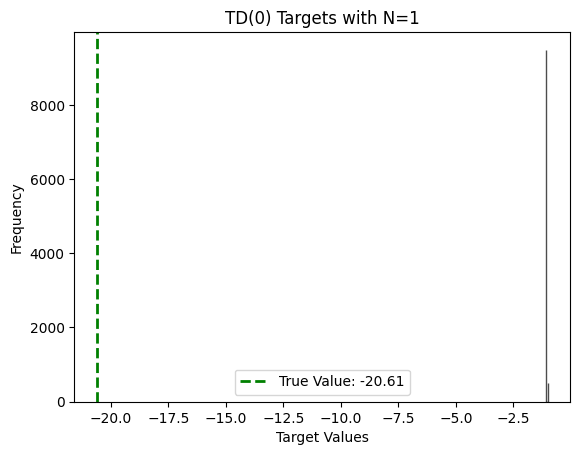

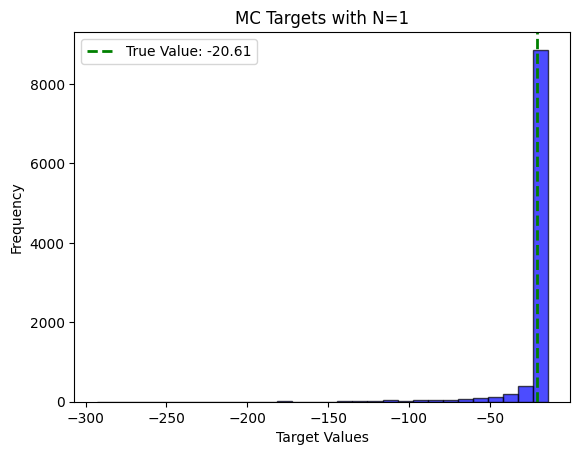

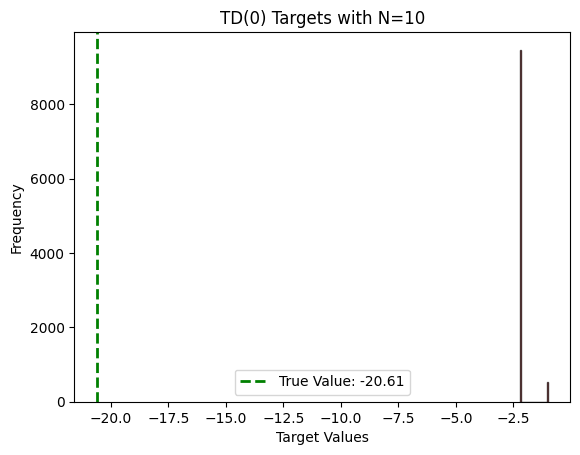

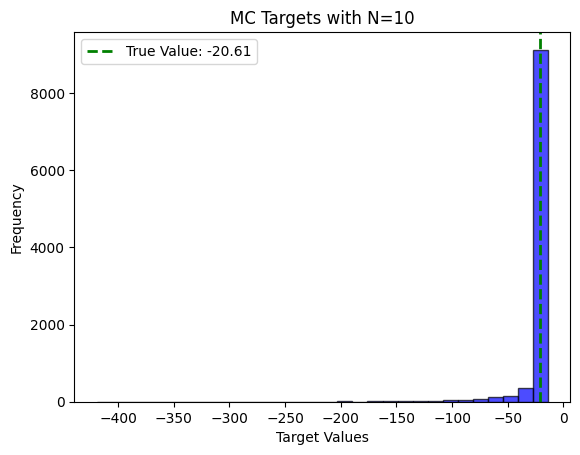

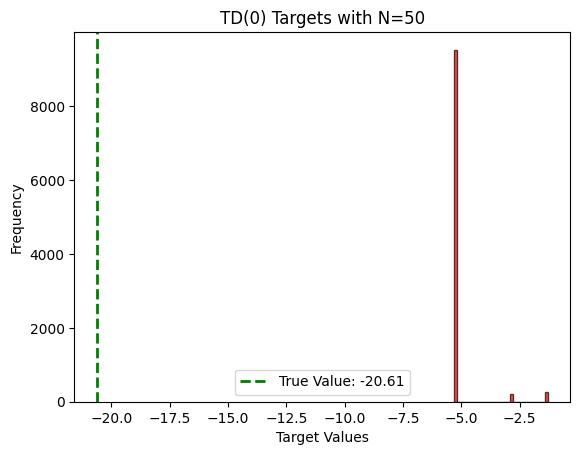

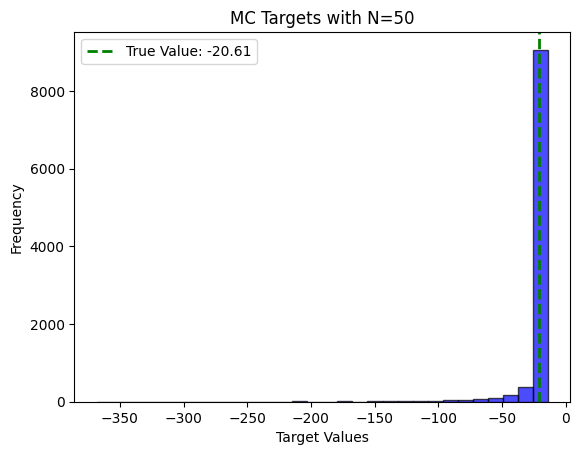

In [14]:
if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(1234)
    random.seed(1234)
    
    environment = WindyGridWorldEnv()
    sarsa_agent = SARSAAgent(environment, alpha=0.5, epsilon=0.1, gamma=1, timeout=8000)
    run_on_policy_mc_td_epsilon_greedy_windy_gridworld(environment, sarsa_agent)